# Deep Convolutional VAE

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import ImageDataset

%matplotlib inline

In [2]:
data_dir = 'datasets/flowers/'
save_data = 'datasets/saved/data.pkl'

In [3]:
data = ImageDataset(data_dir=data_dir, grayscale=False, flatten=True, size=64, logging=True)
# data.create()
# data.save(save_data, force=True)
data = data.load(save_data)

In [4]:
print('Number of training data: {:,}'.format(data.num_examples))

Number of training data: 3,670


### Hyperparameters

In [5]:
# Inputs
image_size = data.size
image_channel = data.channel
image_size_flat = image_size * image_size * image_channel
print('Sizie = {:,} Channels = {:,}'.format(image_size, image_channel))

# Network
filter_size = 5
conv1_size = 32
conv2_size = 64
fc1_size = 1024
hidden_dim = 256
latent_dim = 128
keep_prob = 0.8

# Training
learning_rate = 1e-3
batch_size = 24
iterations = 10000
log_interval = 1000
save_interval = 100

Sizie = 64 Channels = 3


### Helper functions

In [6]:
# weights
def weight(shape, name):
    initial = tf.truncated_normal(shape=shape, mean=0, stddev=0.4)
    return tf.Variable(initial, name=name)

# biases
def bias(shape, name):
    initial = tf.zeros(shape=[shape])
    return tf.Variable(initial, name=name)

def leakyReLU(X, alpha=0.3):
    return tf.maximum(X, tf.multiply(X, alpha))

# convolutional block
def conv(X, W, b):
    layer = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.contrib.layers.batch_norm(layer)
    return layer

# deconvolutional block
def deconv(X, W, b):
    pass

# fully connected block
def dense(X, W, b, activation=leakyReLU, batch_norm=False):
    layer = tf.matmul(X, W) + b
    if activation:
        layer = activation(layer)
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer)
    return layer

# flatten
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=int).prod()
    layer = tf.reshape(layer, [-1, features])
    return layer, features

# Plot images in grid
def plot_images(imgs, size=28, name=None, smooth=False, **kwargs):
    grid = int(np.sqrt(len(imgs)))
    # Create figure with sub-plots.
    fig, axes = plt.subplots(grid, grid)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        interpolation = 'spline16' if smooth else 'nearest'
        # Plot image.
        ax.imshow(imgs[i].reshape([image_size, image_size, image_channel]), interpolation=interpolation, **kwargs)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    if name:
        plt.suptitle(name)
    plt.show()

In [7]:
def encoder(image):
    with tf.name_scope('encoder'):
        image = tf.reshape(image, [-1, image_size, image_size, image_channel])
        # 1st conv layer
        W_conv1 = weight(shape=[filter_size, filter_size, image_channel, conv1_size], name='W_conv1')
        b_conv1 = bias(shape=conv1_size, name='b_conv1')
        conv1 = conv(image, W_conv1, b_conv1)
        # 2nd conv layer
        W_conv2 = weight(shape=[filter_size, filter_size, conv1_size, conv2_size], name='W_conv2')
        b_conv2 = bias(shape=conv2_size, name='b_conv2')
        conv2 = conv(conv1, W_conv2, b_conv2)
        # Flatten
        flattened, feature = flatten(conv2)
        # Fully connected 1
        W_fc1 = weight(shape=[feature, fc1_size], name='W_fc1')
        b_fc1 = bias(shape=fc1_size, name='b_fc1')
        fc1 = dense(flattened, W_fc1, b_fc1, batch_norm=True)
        # Fully connected 2
        W_fc2 = weight(shape=[fc1_size, hidden_dim], name='W_fc2')
        b_fc2 = bias(shape=hidden_dim, name='b_fc2')
        fc2 = dense(fc1, W_fc2, b_fc2, batch_norm=True)
        # Mean
        W_mean = weight(shape=[hidden_dim, latent_dim], name='W_mean')
        b_mean = bias(shape=latent_dim, name='b_mean')
        mean = dense(fc2, W_mean, b_mean, activation=None, batch_norm=True)
        # Stddev
        W_stddev = weight(shape=[hidden_dim, latent_dim], name='W_stddev')
        b_stddev = bias(shape=latent_dim, name='b_stddev')
        stddev = 0.5 * dense(fc2, W_stddev, b_stddev, activation=None, batch_norm=True)
        # Random noise
        noise = tf.random_normal(shape=[1, latent_dim])
        encoded = mean + tf.multiply(noise, tf.exp(0.5 * stddev))
        return encoded, mean, stddev

In [8]:
def decoder(encoded):
    with tf.name_scope('decoder'):
        # Fully connected 1
        W_fc1 = weight(shape=[latent_dim, hidden_dim], name='W_fc1')
        b_fc1 = bias(shape=hidden_dim, name='b_fc1')
        fc1 = dense(encoded, W_fc1, b_fc1, activation=leakyReLU, batch_norm=True)
        # Fully connected 2
        W_fc2 = weight(shape=[hidden_dim, fc1_size], name='W_fc2')
        b_fc2 = bias(shape=fc1_size, name='b_fc2')
        fc2 = dense(fc1, W_fc2, b_fc2, activation=leakyReLU, batch_norm=True)
        # Reconstruction
        W_rec = weight(shape=[fc1_size, image_size_flat], name='W_rec')
        b_rec = bias(shape=image_size_flat, name='b_rec')
        decoded = dense(fc2, W_rec, b_rec, activation=tf.nn.sigmoid)
        return decoded

In [9]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, image_size_flat])

encoded, mean, stddev = encoder(X)
decoded = decoder(encoded)

### Reconstruction loss, KL-Divergence & optimizer

In [10]:
rec_loss = tf.reduce_sum(tf.squared_difference(decoded, X), reduction_indices=1)
kl_term = -0.5 * tf.reduce_sum(1.0 + 2.0 * stddev - tf.square(mean) - tf.exp(2.0 * stddev), reduction_indices=1)
loss = tf.reduce_mean(rec_loss + kl_term)

global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss, global_step=global_step)

## Tensorflow's `tf.Session()`

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Tensorboard

In [12]:
tensorboard_dir = 'tensorboard/'
logdir = os.path.join(tensorboard_dir, 'log')
save_path = 'models/model'

tf.summary.histogram('rec_loss', rec_loss)
tf.summary.histogram('kl_term', kl_term)

tf.summary.scalar('loss', loss)
tf.summary.scalar('kl_term_mean', tf.reduce_mean(kl_term))
tf.summary.scalar('rec_loss_mean', tf.reduce_mean(rec_loss))
rec_img = tf.reshape(decoded, [-1, image_size, image_size, image_channel])
tf.summary.image('rec_img', rec_img, max_outputs=4)
merged = tf.summary.merge_all()

In [13]:
saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir=logdir, graph=sess.graph)

# maybe restore last checkpoint
if tf.gfile.Exists(save_path):
    try:
        sys.stdout.write('\rAttempting to restore the last checkpoint.\n')
        last_ckpt = tf.train.latest_checkpoint(checkpoint_dir=save_path)
        saver.restore(sess=sess, save_path=last_ckpt)
        sys.stdout.write('\rRestored checkpoint from {}'.format(last_ckpt))
    except Exception as e:
        sys.stderr.write('INFO: {}'.format(e))
else:
    tf.gfile.MakeDirs(save_path)
    sys.stdout.write('INFO: Created checkpoint dir: {}'.format(save_path))

INFO: Created checkpoint dir: models/model

## Training

Iter: 1,000	Global step: 999	Loss:195054256.0000	Train time: 0:13:02.179650

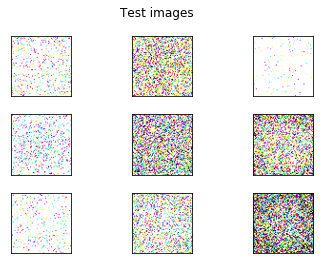

Iter: 2,000	Global step: 1,999	Loss:197462320.0000	Train time: 0:25:34.146880

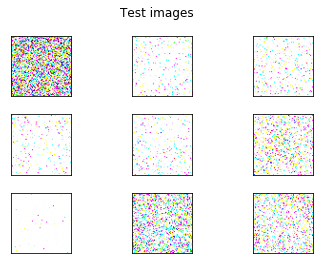

Iter: 3,000	Global step: 2,999	Loss:168808624.0000	Train time: 0:38:01.224683

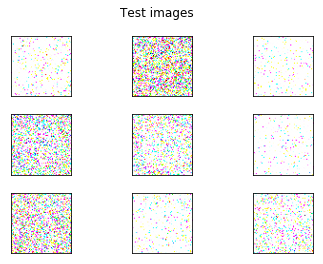

Iter: 4,000	Global step: 3,999	Loss:205686528.0000	Train time: 0:50:34.045648

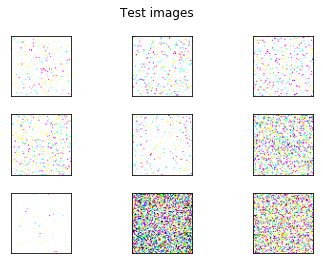

Iter: 4,004	Global step: 4,003	Loss:168999696.0000	Train time: 0:50:40.972921

KeyboardInterrupt: 

In [14]:
start_time = dt.datetime.now()
for i in range(1, iterations+1):
    batch = data.next_batch(batch_size=batch_size)[0]
    _, _i_global, _loss = sess.run([train_step, global_step, loss], feed_dict={X: batch})
    if i % save_interval == 0:
        saver.save(sess=sess, save_path=save_path, global_step=global_step)
        summary = sess.run(merged, feed_dict={X: batch})
        writer.add_summary(summary=summary, global_step=_i_global)
    if i % log_interval == 0:
        random = [np.random.normal(0, 1, latent_dim) for _ in range(9)]
        imgs = sess.run(decoded, feed_dict={encoded: random})
        plot_images(imgs, size=image_size, name='Test images', smooth=True)
    sys.stdout.write('\rIter: {:,}\tGlobal step: {:,}\tLoss:{:.4f}\tTrain time: {}'.format(
        i+1, _i_global, _loss, dt.datetime.now() - start_time))